In [1]:
import numpy as np
import imageio

import tensorflow as tf

import utils

## Settings

In [2]:
INPUT_NODE = 'net/input:0' # ADJUST
OUTPUT_NODE = 'net/fc8/BiasAdd:0' # ADJUST
CLASSES = ['Cat', 'Dog'] # ADJUST
CROP_SIZE = (224, 224) # ADJUST

MODE = 'TF' # ADJUST # TF | TRT

if MODE == 'TF':
    GDEF_PATH = 'data/frozen.pb' # ADJUST
elif MODE == 'TRT':
    GDEF_PATH = 'data/frozen_trt.pb' # ADJUST
    import tensorflow.contrib.tensorrt # Required to init TRTEngineOp

## Load frozen graph and create TF session

In [3]:
graph_def = tf.GraphDef()
with tf.gfile.GFile(GDEF_PATH, "rb") as f:
    graph_def.ParseFromString(f.read())
    
graph = tf.Graph()
with graph.as_default():
    net_inp, net_out = tf.import_graph_def(
        graph_def, return_elements=[INPUT_NODE, OUTPUT_NODE])
    
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)

## Load and prepare input image

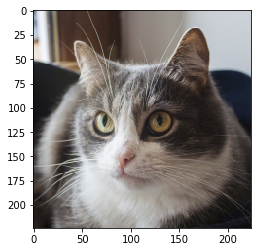

In [4]:
INPUT_IMAGE_PATH = 'img/cat.png' # ADJUST
# INPUT_IMAGE_PATH = '/imagenet/val/ILSVRC2012_val_00004422.JPEG'
# INPUT_IMAGE_PATH = '/imagenet/val/ILSVRC2012_val_00002708.JPEG'

def prepare_image(img_in, crop_size):
    img = utils.resize_and_crop(img_in, crop_size)
    img = img.astype(np.float32)
    img = img[None, ...]
    return img

img = imageio.imread(INPUT_IMAGE_PATH, pilmode='RGB')
img = prepare_image(img, CROP_SIZE)

%matplotlib inline
import matplotlib.pyplot as plt
_=plt.imshow(img[0, ...]/255.)

## Run inference

In [5]:
out = sess.run(net_out, feed_dict={net_inp: img})

print('Output: {}'.format(out))
print('Prediction: {}'.format(CLASSES[np.argmax(out)]))

Output: [[ 6.1986074 -5.7758675]]
Prediction: Cat


## Measure execution time

In [6]:
%%timeit -n 10 -r 10

out = sess.run(net_out, feed_dict={net_inp: img})

4.65 ms ± 129 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Calculate ImageNet validation accuracy

In [7]:
import data_provider
image_list, label_list = data_provider.prepare_sample_list(
    '/imagenet/val/','/imagenet/val.txt', classes=[281, 239])

correct = 0
for img_fpath, label in zip(image_list, label_list):
    img = imageio.imread(img_fpath, pilmode='RGB')
    img = prepare_image(img, CROP_SIZE)
    out = sess.run(net_out, feed_dict={net_inp: img})
    if np.argmax(out) == label:
        correct += 1
        
accuracy = float(correct) / len(image_list)
print('ImageNet validation accuracy: {}'.format(accuracy))

ImageNet validation accuracy: 0.96
